# Using Gurobi to Solve Optimization Problems

---

## D) 

Unmet Demand

---

In [3]:
import numpy as np
from gurobipy import Model, GRB, quicksum

# Supply at each plant
capacity = [1500, 800, 1190, 2900, 1250]

# Demand at each distribution center
demand = [520, 800, 300, 1450, 375, 100, 935, 750, 620]

plants = range(len(capacity))
dcs = range(len(demand))

M = 0

# Transportation costs matrix
cost = [
    [180, 215, 65, 55, 105, 110, 100, 125, 155],
    [110, 175, 95, 145, 165, 120, 80, 160, 205],
    [145, 165, 150, 95, 150, 180, 195, 120, 135],
    [180, 220, 175, 365, 190, 185, 155, 265, 290],
    [135, 165, 160, 65, 130, 150, M, M, M] 
]

M = max(max(row) for row in cost)+1

# Adjusted supply at each plant due to disruptions
capacity[2] = capacity[2]/2  # Plant C at 50% capacity
capacity[3] = capacity[3]/2  # Plant D at 50% capacity

In [4]:
# Create a Gurobi model
model = Model("TransportationProblemWithUnmetDemand")

# Decision variables: x[i, j] is the amount shipped from plant i to DC j
x = model.addVars(len(plants), len(dcs), obj=cost, name="x", vtype=GRB.CONTINUOUS)

# Add constraints

# Add upper bound constraints for specific variables
model.addConstr(x[4, 7-1] == 0, name="UpperBound_x47") # these routes shouldn't be chosen
model.addConstr(x[4, 8-1] == 0, name="UpperBound_x48") # these routes shouldn't be chosen
model.addConstr(x[4, 9-1] == 0, name="UpperBound_x49") # these routes shouldn't be chosen

# Demand constraints: Sum of shipments to each DC must not exceed the necesary demand
model.addConstrs((quicksum(x[i, j] for i in range(len(plants))) <= demand[j] for j in range(len(dcs))), name="Demand") #TODO could add dummy supply node instead

# Supply constraints: Sum of shipments from each plant must use all capacity
model.addConstrs((quicksum(x[i, j] for j in range(len(dcs))) == capacity[i] for i in range(len(plants))), name="Capacity")

# Set objective: Minimize total transportation cost
model.setObjective(
    quicksum(cost[i][j] * x[i, j] for i in plants for j in dcs),
    GRB.MINIMIZE
)

# Optimize the model
model.optimize()

Set parameter Username
Set parameter LicenseID to value 2617769
Academic license - for non-commercial use only - expires 2026-02-04
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17 rows, 45 columns and 93 nonzeros
Model fingerprint: 0xfe239013
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+03]
Presolve removed 3 rows and 3 columns
Presolve time: 0.01s
Presolved: 14 rows, 42 columns, 84 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0902500e+05   4.715766e+02   0.000000e+00      0s
      11    6.5762500e+05   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.576250000e+05


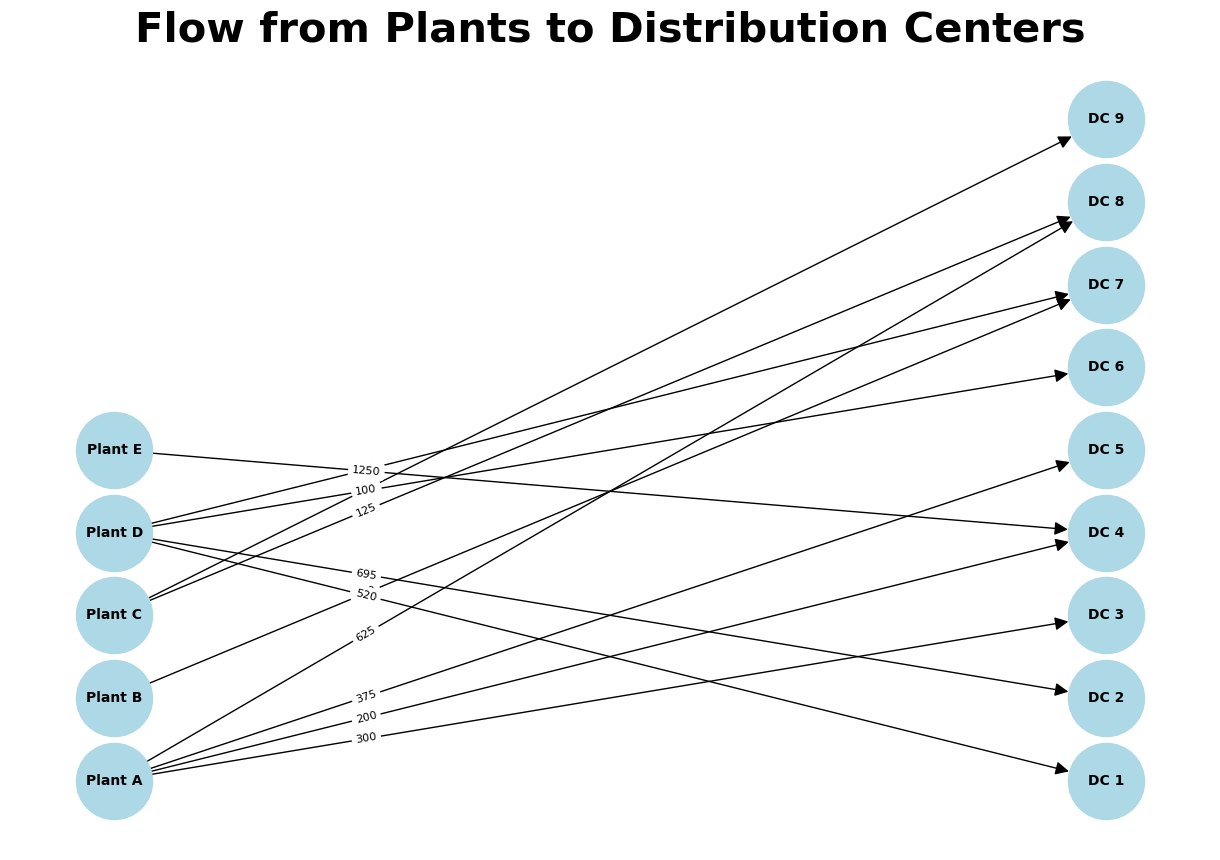

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

plant_to_letter = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}

# Create a directed graph
G = nx.DiGraph()

# Add nodes for plants and DCs
plant_nodes = [f'Plant {plant_to_letter[i]}' for i in plants]
dc_nodes = [f'DC {j+1}' for j in dcs]
G.add_nodes_from(plant_nodes, bipartite=0)
G.add_nodes_from(dc_nodes, bipartite=1)

# Add edges with flow values
edges = []
for i in plants:
    for j in dcs:
        if x[i, j].x > 0:
            edges.append((f'Plant {plant_to_letter[i]}', f'DC {j+1}', x[i, j].x))

G.add_weighted_edges_from(edges)

# Position nodes using bipartite layout
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(plant_nodes))
pos.update((node, (2, index)) for index, node in enumerate(dc_nodes))

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
# Adjust the position of edge labels to avoid overlap
edge_labels = {(u, v): f'{d["weight"]:.0f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.25)
plt.title('Flow from Plants to Distribution Centers', fontsize=30, fontweight='bold')
plt.show()


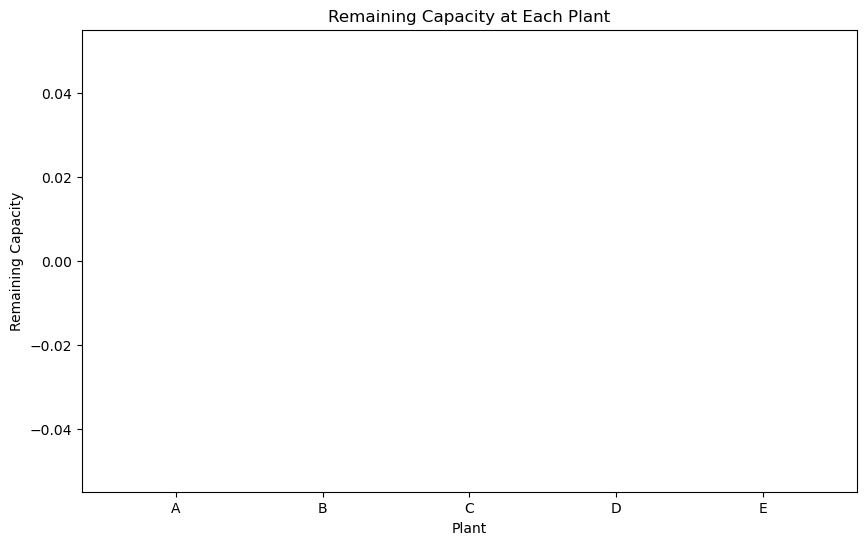

Remaining capacity at Plant A: 0.0
Remaining capacity at Plant B: 0.0
Remaining capacity at Plant C: 0.0
Remaining capacity at Plant D: 0.0
Remaining capacity at Plant E: 0.0


In [6]:
remaining_capacity = [capacity[i] - sum(x[i, j].x for j in dcs) for i in plants]

# Visualize remaining capacity in a single bar graph
plt.figure(figsize=(10, 6))
plt.bar([plant_to_letter[i] for i in plants], remaining_capacity, color='skyblue')
plt.xlabel('Plant')
plt.ylabel('Remaining Capacity')
plt.title('Remaining Capacity at Each Plant')
plt.show()

# Print remaining capacity for each plant
for i in plants:
    print(f"Remaining capacity at Plant {plant_to_letter[i]}: {remaining_capacity[i]}")

Unmet demand at DC 1: 0.0
Unmet demand at DC 2: 105.0
Unmet demand at DC 3: 0.0
Unmet demand at DC 4: 0.0
Unmet demand at DC 5: 0.0
Unmet demand at DC 6: 0.0
Unmet demand at DC 7: 0.0
Unmet demand at DC 8: 0.0
Unmet demand at DC 9: 150.0


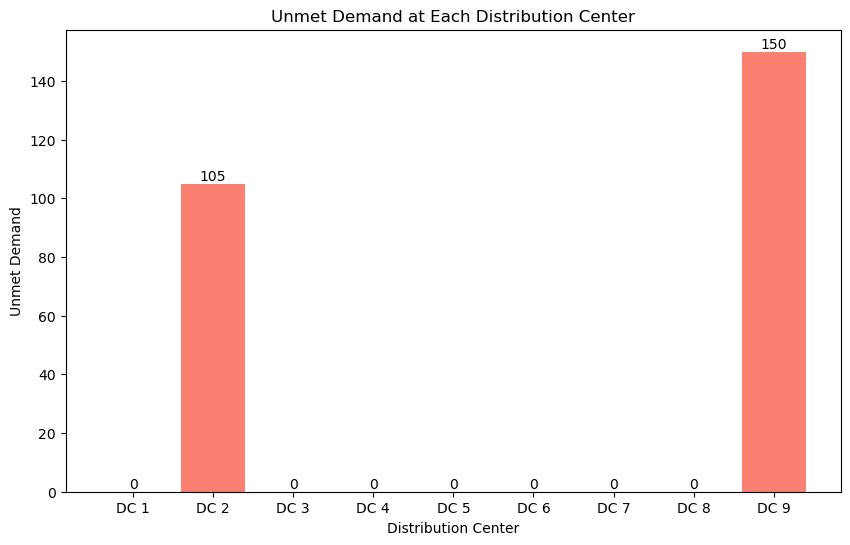

In [7]:
unmet_demand = [demand[j] - sum(x[i, j].x for i in plants) for j in dcs]

# Print unmet demand for each DC
for j in dcs:
    print(f"Unmet demand at DC {j+1}: {unmet_demand[j]}")
# Visualize unmet demand in a single bar graph with labels
plt.figure(figsize=(10, 6))
bars = plt.bar([f'DC {j+1}' for j in dcs], unmet_demand, color='salmon')
plt.xlabel('Distribution Center')
plt.ylabel('Unmet Demand')
plt.title('Unmet Demand at Each Distribution Center')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.show()

In [8]:
import csv

# Save results to a CSV file
print(["Optimal cost", model.objVal])
with open("hw3-1-d-soln.csv", "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Plant", "DC", "Units Shipped"])
    if model.status == GRB.OPTIMAL:
        for i in range(len(plants)):
            for j in range(len(dcs)):
                if x[i, j].x > 0:
                    print(f"Ship {x[i, j].x} units from Plant {plant_to_letter[plants[i]]} to DC {dcs[j]+1}")
                    csvwriter.writerow([plant_to_letter[plants[i]], dcs[j]+1, x[i, j].x])
    else:
        csvwriter.writerow(["No optimal solution found"])


['Optimal cost', 657625.0]
Ship 300.0 units from Plant A to DC 3
Ship 200.0 units from Plant A to DC 4
Ship 375.0 units from Plant A to DC 5
Ship 625.0 units from Plant A to DC 8
Ship 800.0 units from Plant B to DC 7
Ship 125.0 units from Plant C to DC 8
Ship 470.0 units from Plant C to DC 9
Ship 520.0 units from Plant D to DC 1
Ship 695.0 units from Plant D to DC 2
Ship 100.0 units from Plant D to DC 6
Ship 135.0 units from Plant D to DC 7
Ship 1250.0 units from Plant E to DC 4
